In [1]:
import matplotlib.pyplot as plt
from osgeo import gdal
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cf
from scipy.ndimage import zoom
from scipy.signal import savgol_filter
import matplotlib.ticker as mticker
import matplotlib.ticker as mtick
import matplotlib as mpl
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import datetime
from PIL import ImageColor
from generativepy.color import Color
from matplotlib.colors import rgb2hex
from matplotlib.colors import to_rgba
import matplotlib.colors as mcolors
import geopandas as gpd
import xarray as xr
from shapely.geometry import mapping
import rioxarray
from matplotlib import gridspec
import rasterio
import cartopy.io.shapereader as shpreader
warnings.filterwarnings('ignore')

start_t = datetime.datetime.now()
print('start:', start_t)

def read_data(image_data):
    dataset = gdal.Open(image_data)
    geotransform = dataset.GetGeoTransform()
    origin_x,origin_y = geotransform[0],geotransform[3]
    pixel_width, pixel_height = geotransform[1],geotransform[5]
    
    width, height = dataset.RasterXSize, dataset.RasterYSize
    lon = origin_x + pixel_width * np.arange(width)
    lat = origin_y + pixel_height * np.arange(height)
    
    data = dataset.GetRasterBand(1).ReadAsArray()
    nodata_value = dataset.GetRasterBand(1).GetNoDataValue()
    if nodata_value is not None:
        data = np.ma.masked_equal(data, nodata_value)
    data = np.ma.masked_equal(data, 0)
    dataset = None
    return data,lon,lat,geotransform

def custom_colormap(i, j, n):
    # Normalize the indices to the range [0, 1]
    x = i / (n - 1)
    y = j / (n - 1)
    # Compute the distance from the center
    distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)
    # Define the color components based on distance from center
    g = np.clip(distance + (x - 0.5), 0, 1)
    r = np.clip(distance + (y - 0.5), 0, 1)
    b = np.clip(1 - distance, 0, 1)
    return (r, g, b, 1)

def country_extraction(global_data,lat,lon,country_shp):
    file = xr.DataArray(global_data, coords=[('lat', lat), ('lon', lon), ('channel', [1, 2, 3, 4])])
    ds = xr.Dataset({'data': file})
    ds.rio.write_crs("EPSG:4326", inplace=True)
    ds = ds.rename({'lon': 'x'})
    ds = ds.rename({'lat': 'y'})
    clipped = ds.rio.clip(country_shp.geometry.apply(mapping), country_shp.crs, drop=False)
    region_data = clipped.variables['data']
    return region_data
def base_map(ax):
    states_provinces = cf.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',
                                              scale='50m',facecolor='none')
    ax.add_feature(cf.LAND,alpha=0.1)
    ax.add_feature(cf.BORDERS, linestyle='--',lw=0.4, alpha=0.5)
    ax.add_feature(cf.LAKES, alpha=0.5)
    ax.add_feature(cf.OCEAN,alpha=0.1,zorder = 2)
    ax.add_feature(cf.COASTLINE,lw=0.4)
    ax.add_feature(cf.RIVERS,lw=0.2)
    ax.add_feature(states_provinces,lw=0.2,edgecolor='gray')
    return


start: 2024-03-25 12:44:06.983448


In [12]:
from osgeo import gdal

# Load the TIFF file
file_path = 'G:/Hangkai/Global forest edge/001degree/absolute_color_array_01_2.tif'
dataset = gdal.Open(file_path)

# Get the projection information
projection = dataset.GetProjection()
print("Projection:\n", projection)

# Get geotransform and calculate bounds
geotransform = dataset.GetGeoTransform()
x_min = geotransform[0]
y_max = geotransform[3]
x_max = x_min + geotransform[1] * dataset.RasterXSize
y_min = y_max - abs(geotransform[5]) * dataset.RasterYSize  # Correct calculation for y_min

print("Extent (in geographic coordinates):")
print(f"X Min: {x_min}")
print(f"Y Max: {y_max}")
print(f"X Max: {x_max}")
print(f"Y Min: {y_min}")

# Get the resolution (pixel size)
x_res = geotransform[1]
y_res = abs(geotransform[5])
print("Resolution:")
print(f"X Resolution: {x_res}")
print(f"Y Resolution: {y_res}")


Projection:
 GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Extent (in geographic coordinates):
X Min: -180.0
Y Max: 80.0
X Max: 180.0
Y Min: -60.0
Resolution:
X Resolution: 0.01
Y Resolution: 0.01


In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as cfeature
import rasterio
import gc


color_array_file = 'G:/Hangkai/Global forest edge/001degree/absolute_color_array_01_2.tif'

with rasterio.open(color_array_file) as src:
    color_array_float32 = np.stack((src.read(1), src.read(2), src.read(3), src.read(4)), axis=-1, dtype=np.float32)
gc.collect()


6

MemoryError: Unable to allocate 3.76 GiB for an array with shape (504000000,) and data type float64

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

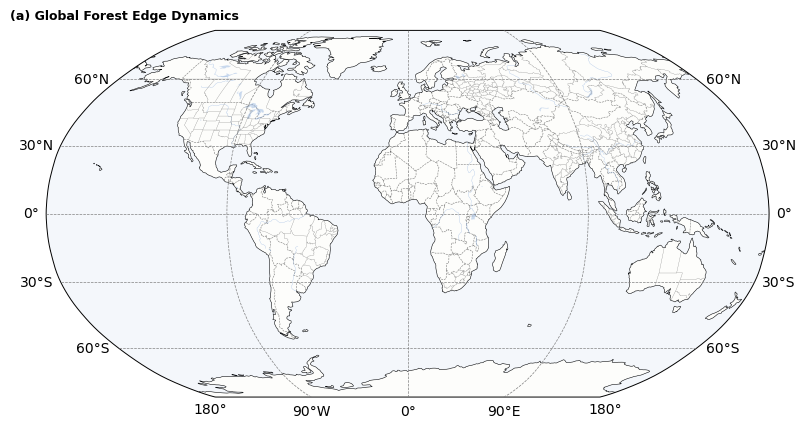

In [3]:
extent = [-180.0, 180.0, -60.0, 80.0]
n = 40
def custom_colormap(i, j, n):
    # Normalize the indices to the range [0, 1]
    x = i / (n - 1)
    y = j / (n - 1)
    
    # Compute the distance from the center
    distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)
    
    # Define the color components based on distance from center
    g = np.clip(distance + (x - 0.5), 0, 1)
    r = np.clip(distance + (y - 0.5), 0, 1)
    b = np.clip(1 - distance, 0, 1)
    
    return (r, g, b, 1)

# Create an array representing the custom colormap
bivariate_colors = np.empty((n, n, 4))  # Initialize an empty array to store RGBA values


world_filepath = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_0_countries')
world = gpd.read_file(world_filepath)
countries = ['United States of America','China', 'Taiwan','Russia','Brazil','Canada']
selected_countries = world[world['SOVEREIGNT'].isin(countries)]
china = selected_countries[(selected_countries['SOVEREIGNT']=='China')|(selected_countries['SOVEREIGNT']=='Taiwan')]
us = selected_countries[(selected_countries['SOVEREIGNT']=='United States of America')&(selected_countries['TYPE']=='Country')]
russia = selected_countries[selected_countries['SOVEREIGNT']=='Russia']
brazil = selected_countries[selected_countries['SOVEREIGNT']=='Brazil']
canada = selected_countries[selected_countries['SOVEREIGNT']=='Canada']
contries_shp = [china, us, russia, brazil, canada]

fig = plt.figure(figsize = (10,10))
gs = gridspec.GridSpec(21, 6)
config = {"font.family":'Helvetica'}
plt.subplots_adjust(hspace =0,wspace =0.25)
plt.rcParams.update(config)

####################### global data
ax = plt.subplot(gs[0:10, :],projection = ccrs.Robinson(central_longitude=0.0))

base_map(ax)
grd = ax.gridlines(draw_labels=True, xlocs=range(-180, 181, 90), ylocs=range(-60, 61, 30), color='gray',linestyle='--', linewidth=0.5, zorder=7)
grd.top_labels = False

ax.tick_params(axis='both',which='major',labelsize=8,direction='out',length=3,width=0.5,pad=1.3,labelleft = True, labelbottom = True,
                bottom=True,left=True,top=False,right=False)
ax.spines['geo'].set_linewidth(0.7)
ax.text(-0.05,1.03, '(a) Global Forest Edge Dynamics', transform=ax.transAxes, fontsize = 9,fontweight='bold')
#ax.imshow(color_array_float32, extent = extent,transform=ccrs.PlateCarree(),zorder = 3)
ax.imshow(color_array_float32, extent = extent,transform=ccrs.PlateCarree())


china.plot(ax = ax,transform=ccrs.PlateCarree(),color = 'none',edgecolor="k",lw = 0.5)
us.plot(ax = ax,transform=ccrs.PlateCarree(),color = 'none',edgecolor="k",lw = 0.5)
russia.plot(ax = ax,transform=ccrs.PlateCarree(),color = 'none',edgecolor="k",lw = 0.5)
brazil.plot(ax = ax,transform=ccrs.PlateCarree(),color = 'none',edgecolor="k",lw = 0.5)
canada.plot(ax = ax,transform=ccrs.PlateCarree(),color = 'none',edgecolor="k",lw = 0.5)

axx = ax.inset_axes([0.05,0.15,0.25,0.25])
axx.set_aspect('equal', adjustable='box')

axx.imshow(bivariate_colors, origin='lower', extent=[0, 1, 0, 1])

axx.tick_params(axis='both',which='major',bottom=False, left=False,top=False,right=False,labelleft = False, labelbottom = False)
axx.spines[['top', 'right','left','bottom']].set_visible(False)
axx.set_title('Forest Dynamics',fontsize = 8)
axx.set_xlabel('edge changes',fontsize = 6,labelpad = 8)
axx.set_ylabel('area chenges',fontsize = 6,labelpad = 8)
axx.text(1,-0.07, '+4 $km$', transform=axx.transAxes, fontsize = 6)
axx.text(0,-0.07, '-4 $km$', transform=axx.transAxes, fontsize = 6)
axx.text(-0.12,0.78, '+0.2 $km^2$', transform=axx.transAxes, fontsize = 6,rotation= 90)
axx.text(-0.12,0, '-0.2 $km^2$', transform=axx.transAxes, fontsize = 6,rotation= 90)


####################### regional data
ax1 = plt.subplot(gs[11:16, 0:2],projection = ccrs.PlateCarree())
ax2 = plt.subplot(gs[11:16, 2:4],projection = ccrs.PlateCarree())
ax4 = plt.subplot(gs[11:16, 4:6],projection = ccrs.PlateCarree())
ax3 = plt.subplot(gs[16:21, 0:4],projection = ccrs.PlateCarree())
ax5 = plt.subplot(gs[16:21, 4:6],projection = ccrs.PlateCarree())

ax1.text(0,1.05, '(b) Forest Edge Dynamics in Different Countries', transform=ax1.transAxes, fontsize = 9,fontweight='bold')
ax1.text(0.02,0.9, '(b.1) China', transform=ax1.transAxes, fontsize = 8)
ax2.text(0.02,0.9, '(b.2) U.S. mainland', transform=ax2.transAxes, fontsize = 8)
ax4.text(0.02,0.9, '(b.3) Brazil', transform=ax4.transAxes, fontsize = 8)
ax3.text(0.02,0.9, '(b.4) Russia', transform=ax3.transAxes, fontsize = 8)
ax5.text(0.02,0.9, '(b.5) Canada', transform=ax5.transAxes, fontsize = 8)

d1 = country_extraction(color_array_float32,lat1,lon1,china)
d2 = country_extraction(color_array_float32,lat1,lon1,us)
d3 = country_extraction(color_array_float32,lat1,lon1,russia)
d4 = country_extraction(color_array_float32,lat1,lon1,brazil)
d5 = country_extraction(color_array_float32,lat1,lon1,canada)

base_map(ax1)
base_map(ax2)
base_map(ax3)
base_map(ax4)
base_map(ax5)

ax1.imshow(d1, extent = [lon1.min(), lon1.max(), lat1.min(), lat1.max()],transform=ccrs.PlateCarree(), zorder = 3)
ax2.imshow(d2, extent = [lon1.min(), lon1.max(), lat1.min(), lat1.max()],transform=ccrs.PlateCarree(), zorder = 3)
ax3.imshow(d3, extent = [lon1.min(), lon1.max(), lat1.min(), lat1.max()],transform=ccrs.PlateCarree(), zorder = 3)
ax4.imshow(d4, extent = [lon1.min(), lon1.max(), lat1.min(), lat1.max()],transform=ccrs.PlateCarree(), zorder = 3)
ax5.imshow(d5, extent = [lon1.min(), lon1.max(), lat1.min(), lat1.max()],transform=ccrs.PlateCarree(), zorder = 3)

china.plot(ax = ax1,transform=ccrs.PlateCarree(),color = 'none',edgecolor="k",lw = 0.5)
us.plot(ax = ax2,transform=ccrs.PlateCarree(),color = 'none',edgecolor="k",lw = 0.5)
russia.plot(ax = ax3,transform=ccrs.PlateCarree(),color = 'none',edgecolor="k",lw = 0.5)
brazil.plot(ax = ax4,transform=ccrs.PlateCarree(),color = 'none',edgecolor="k",lw = 0.5)
canada.plot(ax = ax5,transform=ccrs.PlateCarree(),color = 'none',edgecolor="k",lw = 0.5)

ax1.set_extent([69, 137, 14, 50])
ax2.set_extent([-128, -60, 18, 54])
ax3.set_extent([20, 179, 40, 75])
ax4.set_extent([-90, -22, -31, 5])
ax5.set_extent([-145, -50, 30, 85])

ax1.set_xticks([80,100,120])
ax2.set_xticks([-120,-100,-80,-60])
ax3.set_xticks([30,60,90,120,150])
ax4.set_xticks([-80,-60,-40])
ax5.set_xticks([-140,-120,-100,-80, -60])

ax1.set_yticks([20,35,50])                 
ax2.set_yticks([30,50])
ax3.set_yticks([45,60,75])
ax4.set_yticks([-30,-15, 0])
ax5.set_yticks([40,60,80])

ax1.set_yticklabels([x.get_text() for x in ax1.get_yticklabels()],rotation=90, va='center')
ax2.set_yticklabels([x.get_text() for x in ax2.get_yticklabels()],rotation=90, va='center')
ax3.set_yticklabels([x.get_text() for x in ax3.get_yticklabels()],rotation=90, va='center')
ax4.set_yticklabels([x.get_text() for x in ax4.get_yticklabels()],rotation=90, va='center')
ax5.set_yticklabels([x.get_text() for x in ax5.get_yticklabels()],rotation=90, va='center')

ax1.xaxis.set_major_formatter(LongitudeFormatter()) 
ax2.xaxis.set_major_formatter(LongitudeFormatter()) 
ax3.xaxis.set_major_formatter(LongitudeFormatter()) 
ax4.xaxis.set_major_formatter(LongitudeFormatter()) 
ax5.xaxis.set_major_formatter(LongitudeFormatter()) 
                   
ax1.yaxis.set_major_formatter(LatitudeFormatter())
ax2.yaxis.set_major_formatter(LatitudeFormatter())
ax3.yaxis.set_major_formatter(LatitudeFormatter())
ax4.yaxis.set_major_formatter(LatitudeFormatter())
ax5.yaxis.set_major_formatter(LatitudeFormatter())

ax1.tick_params(axis='both',which='major',labelsize=8,direction='out',length=3,width=0.5,pad=1.3,labelleft = True, labelbottom = True, bottom=True,left=True,top=False,right=False)
ax2.tick_params(axis='both',which='major',labelsize=8,direction='out',length=3,width=0.5,pad=1.3,labelleft = True, labelbottom = True, bottom=True,left=True,top=False,right=False)
ax3.tick_params(axis='both',which='major',labelsize=8,direction='out',length=3,width=0.5,pad=1.3,labelleft = True, labelbottom = True, bottom=True,left=True,top=False,right=False)
ax4.tick_params(axis='both',which='major',labelsize=8,direction='out',length=3,width=0.5,pad=1.3,labelleft = True, labelbottom = True, bottom=True,left=True,top=False,right=False)
ax5.tick_params(axis='both',which='major',labelsize=8,direction='out',length=3,width=0.5,pad=1.3,labelleft = True, labelbottom = True, bottom=True,left=True,top=False,right=False)

ax1.spines['geo'].set_linewidth(0.7)
ax2.spines['geo'].set_linewidth(0.7)
ax3.spines['geo'].set_linewidth(0.7)
ax4.spines['geo'].set_linewidth(0.7)
ax5.spines['geo'].set_linewidth(0.7)

plt.savefig('G:/Hangkai/Forest_edge_mapping_data/Global_001_degree/Figure S1_Forest edge dynamics_absolute_difference.png', dpi=600, bbox_inches='tight')

end_t = datetime.datetime.now()
elapsed_sec = (end_t - start_t).total_seconds()
print('end:', end_t)
print('total:',elapsed_sec/60, 'min')